In [1]:
import astropy.io.fits as fits
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import treecorr
import matplotlib.pyplot as plt
import healpy as hp

In [27]:
# Load only necessary columns from the galaxy shape catalogue
shape_cat_path = '/n17data/mkilbing/astro/data/CFIS/v1.x/ShapePipe/v1.5.x/v1.5.3/unions_shapepipe_cut_struc_2024_v1.5.3.fits'
shapes = fits.open(shape_cat_path)[1].data


In [ ]:
# Load only necessary columns from the galaxy sample
galaxy_sample_path = '/home/hervas/fhervas/data_SDSS/eBOSS_LRGpCMASS_clustering_data-NGC-vDR16.fits'
galaxy_sample_path = '/home/hervas/fhervas/data_SDSS/eBOSS_LRG_full_ALLdata-vDR16.fits'
galaxy_sample_path = '/home/hervas/fhervas/data_SDSS/galaxy_DR12v5_CMASS_North.fits'
galaxies = fits.open(galaxy_sample_path)[1].data

In [15]:
len( galaxies )

311848

In [125]:
eboss_randoms_path = '/home/hervas/fhervas/data_SDSS/eBOSS_LRG_clustering_random-SGC-vDR16.fits'
eboss_randoms_path = '/home/hervas/fhervas/data_SDSS/random_DR14_LRG_S.fits'
s_eboss_randoms = fits.open(eboss_randoms_path)[1].data

In [126]:
eboss_randoms_path = '/home/hervas/fhervas/data_SDSS/eBOSS_LRG_clustering_random-NGC-vDR16.fits'
eboss_randoms_path = '/home/hervas/fhervas/data_SDSS/random_DR14_LRG_N.fits'
n_eboss_randoms = fits.open(eboss_randoms_path)[1].data

In [127]:
randoms = np.concatenate( (s_eboss_randoms, n_eboss_randoms) )

In [128]:
len( randoms ) , len( n_eboss_randoms ) + len( s_eboss_randoms) , len( galaxies )

(5197669, 5197669, 311848)

In [25]:
galaxy_sample.columns

ColDefs(
    name = 'RUN'; format = 'I'; null = 16959
    name = 'CAMCOL'; format = 'I'; null = 16959
    name = 'FIELD'; format = 'I'; null = 16959
    name = 'ID'; format = 'I'; null = 16959
    name = 'RERUN'; format = '12A'
    name = 'FIBER2MAG'; format = '5E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'PSFFLUX'; format = '5E'
    name = 'PSFFLUX_IVAR'; format = '5E'
    name = 'EXTINCTION'; format = '5E'
    name = 'FIBER2FLUX'; format = '5E'
    name = 'FIBER2FLUX_IVAR'; format = '5E'
    name = 'MODELFLUX'; format = '5E'
    name = 'MODELFLUX_IVAR'; format = '5E'
    name = 'MODELMAG'; format = '5E'
    name = 'W1_MAG'; format = 'E'
    name = 'W1_MAG_ERR'; format = 'E'
    name = 'W1_NANOMAGGIES'; format = 'E'
    name = 'W1_NANOMAGGIES_IVAR'; format = 'E'
    name = 'W2_NANOMAGGIES'; format = 'E'
    name = 'W2_NANOMAGGIES_IVAR'; format = 'E'
    name = 'OBJID_TARGETING'; format = 'K'; null = 999999
    name = 'CHUNK'; format = 'J'; null = 999999


In [130]:
# # Create SkyCoord objects for matching
# galaxy_coords = coord.SkyCoord(ra=galaxies['RA']*u.degree, dec=galaxies['DEC']*u.degree)
# shape_coords = coord.SkyCoord(ra=shapes['RA']*u.degree, dec=shapes['Dec']*u.degree)

# # Perform the matching
# idx, d2d, d3d = galaxy_coords.match_to_catalog_sky(shape_coords)

# # Apply a maximum separation criterion (e.g., 1 arcsecond)
# max_sep = 1 * u.arcsec
# matches = d2d < max_sep

In [ ]:
# len( galaxies['RA'][matches] )

124450

In [ ]:
# # Filter the matched catalogues
# matched_galaxy_ra = galaxies['RA'][matches]
# matched_galaxy_dec = galaxies['DEC'][matches]
# matched_galaxy_redshift = galaxies['Z'][matches]
# matched_shape_ra = shapes['RA'][idx[matches]]
# matched_shape_dec = shapes['Dec'][idx[matches]]
# matched_shape_e1 = shapes['e1'][idx[matches]]
# matched_shape_e2 = shapes['e2'][idx[matches]]
# matched_shape_w = shapes['w_iv'][idx[matches]]

In [ ]:
# # Create a new FITS table with the matched columns
# cols = [
#     fits.Column(name='RA', format='E', array=matched_galaxy_ra),
#     fits.Column(name='Dec', format='E', array=matched_galaxy_dec),
#     fits.Column(name='e1', format='E', array=matched_shape_e1),
#     fits.Column(name='e2', format='E', array=matched_shape_e2),
#     fits.Column(name='w_iv', format='E', array=matched_shape_w),
#     fits.Column(name='galaxy_RA', format='E', array=matched_galaxy_ra),
#     fits.Column(name='galaxy_Dec', format='E', array=matched_galaxy_dec),
#     fits.Column(name='redshift', format='E', array=matched_galaxy_redshift)
# ]

# hdu = fits.BinTableHDU.from_columns(cols)
# hdu.writeto('unions_lrg_catalogue.fits', overwrite=True)

In [33]:
shape_position_catalogue = fits.open('unions_lrg_catalogue.fits')[1].data

In [34]:
theta_bins = np.linspace( 0 , 5 , 100 )
theta_cents = ( theta_bins[1:] + theta_bins[:-1] )/2.
counts, _ = np.histogram( d2d.arcsec[ d2d.arcsec < 5 ] , bins = theta_bins )

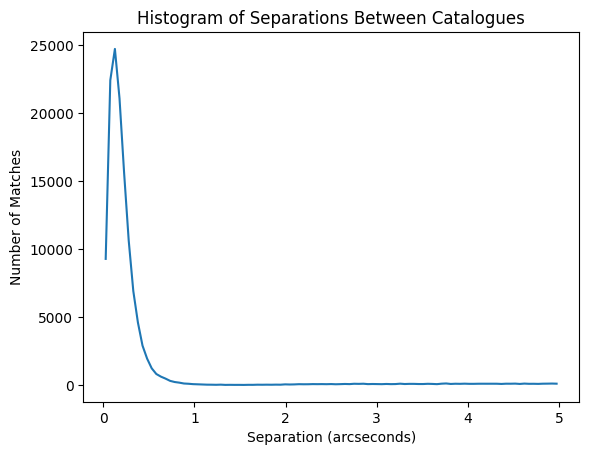

In [35]:
# Plot the histogram
plt.plot( theta_cents , counts )
plt.xlabel('Separation (arcseconds)')
plt.ylabel('Number of Matches')
plt.title('Histogram of Separations Between Catalogues')
plt.show()

In [36]:
len( shape_position_catalogue )

124450

In [37]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM( 70 , 0.3 )

In [40]:
ra = 'Ra'
dec = 'DEC'
redshift = 'redshift'

In [41]:
import healpy as hp

In [43]:
randoms

array([( 23.35623286,  1.17905996, 0.79479114, 0.61168021, 0.8866377 , 1.5, 1.01726957, 6.34841178e-05),
       (  8.93419978,  2.4284576 , 0.72744616, 0.53519335, 0.90360839, 1. , 1.0266448 , 8.68483601e-05),
       (345.7546034 ,  2.59529232, 0.87223978, 0.77368395, 1.04140159, 1. , 1.01267143, 2.92517437e-05),
       ...,
       (231.09251179, 33.43160771, 0.90248545, 0.81052198, 0.6773224 , 1. , 1.05479525, 2.33772827e-05),
       (212.6337694 , 45.06639265, 0.64552769, 0.51224016, 0.93081197, 1. , 1.03236013, 9.52209300e-05),
       (254.28313325, 31.98356491, 0.62276655, 0.54680461, 1.036675  , 1. , 1.01830059, 8.28806822e-05)],
      dtype=[('RA', '<f8'), ('DEC', '<f8'), ('Z', '<f8'), ('WEIGHT_FKP', '<f8'), ('WEIGHT_SYSTOT', '<f8'), ('WEIGHT_CP', '<f8'), ('WEIGHT_NOZ', '<f8'), ('NZ', '<f8')])

In [137]:
# remove random shapes and positions outside of the survey footprints
# Convert RA, Dec to HEALPix pixel indices
nside = 128
pixels_positions = hp.ang2pix(nside, galaxies['RA'], galaxies['Dec'] , lonlat=True)
# pixels_shapes = hp.ang2pix(nside,  shape_position_catalogue[ra], shape_position_catalogue[dec] , lonlat=True)
#pixels_unions_shapes = hp.ang2pix(nside,  shapes['Ra'], shapes['Dec'] , lonlat=True)
pixels_random_positions = hp.ang2pix(nside,  randoms['RA'], randoms['DEC'] , lonlat=True)

# Create HEALPix count maps
position_map = np.bincount(pixels_positions, minlength=hp.nside2npix(nside))
# shape_map = np.bincount(pixels_shapes, minlength=hp.nside2npix(nside))
#unions_shape_map = np.bincount(pixels_unions_shapes, minlength=hp.nside2npix(nside))
random_position_map = np.bincount(pixels_random_positions, minlength=hp.nside2npix(nside))

# Create a mask: pixels with at least one object
position_mask = (position_map > 0) 
shape_mask = (shape_map>0) 

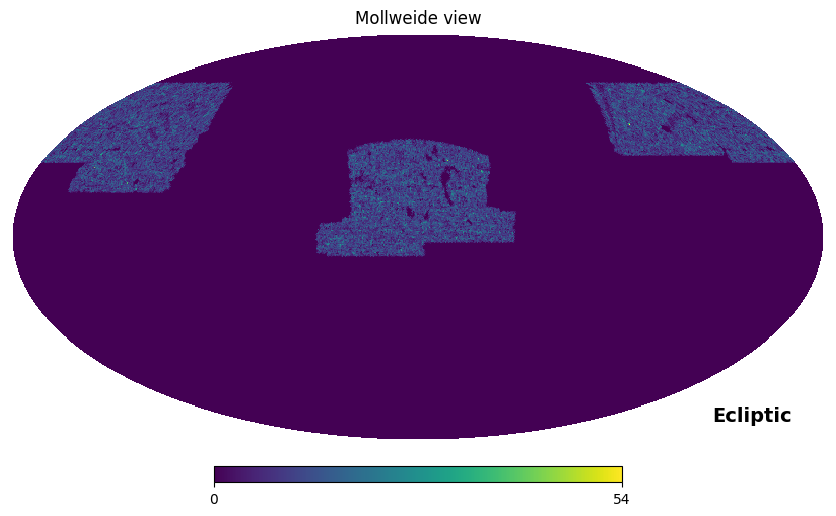

In [138]:
hp.mollview( position_map , coord ='E' )

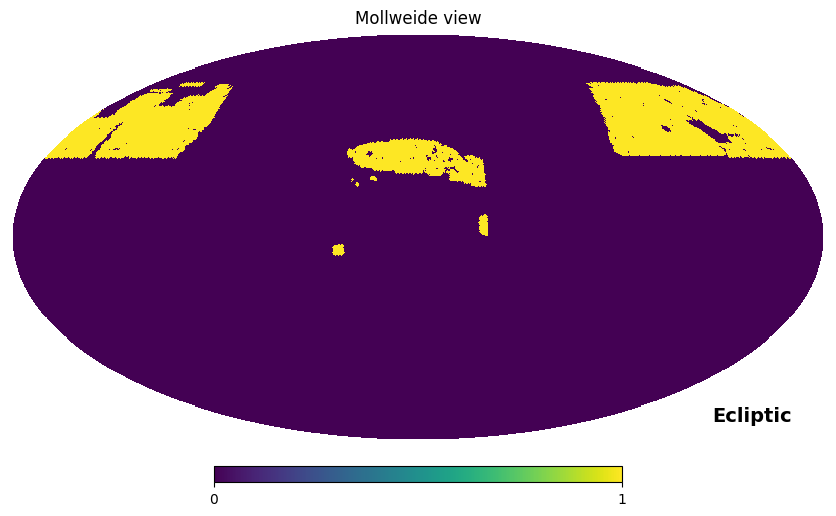

In [139]:
hp.mollview( shape_mask , coord ='E' )

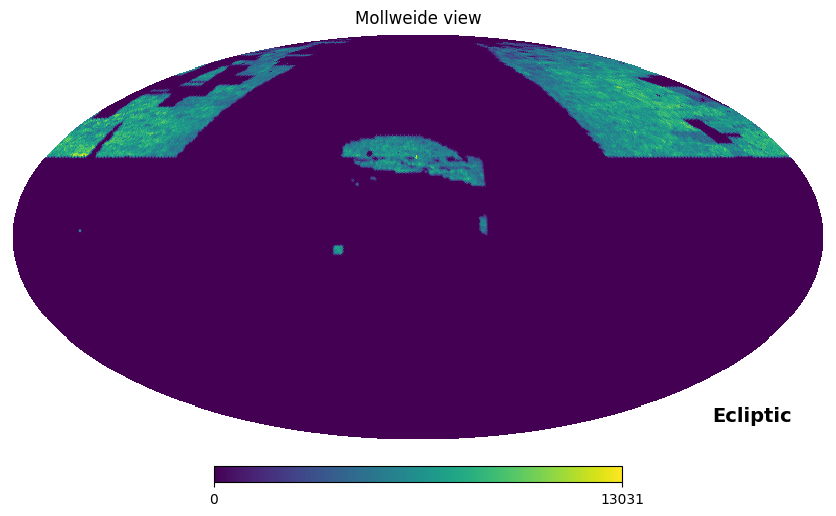

In [140]:
hp.mollview( unions_shape_map, coord ='E' )

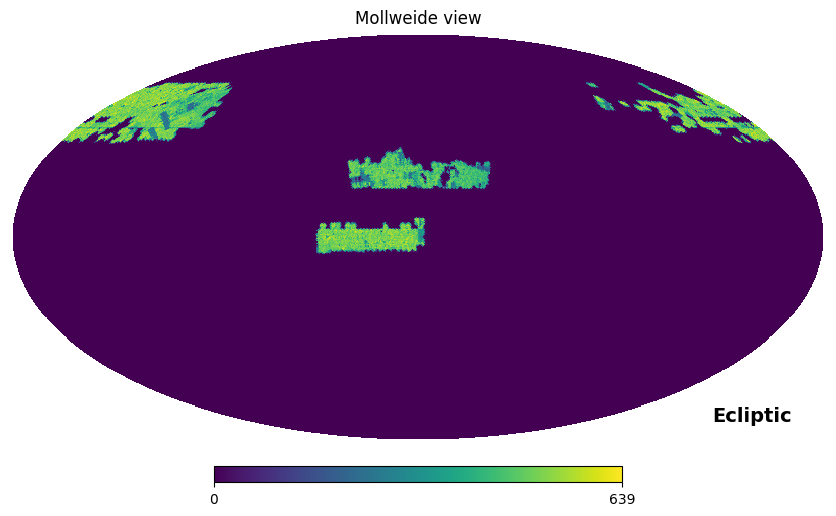

In [141]:
hp.mollview( random_position_map , coord ='E' )

In [50]:
len( randoms  )/len( galaxies ), len( randoms  )/len( shape_position_catalogue )

(28.58499012339345, 71.62854158296504)

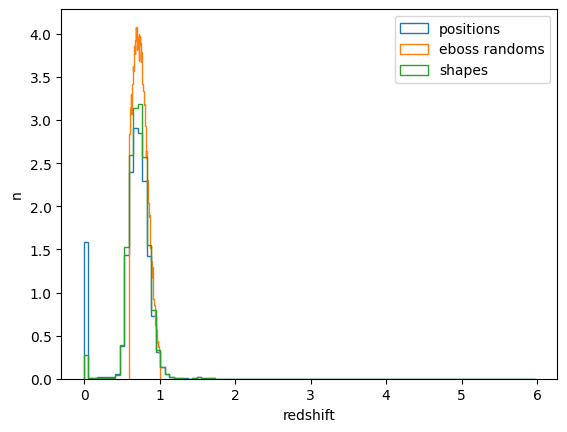

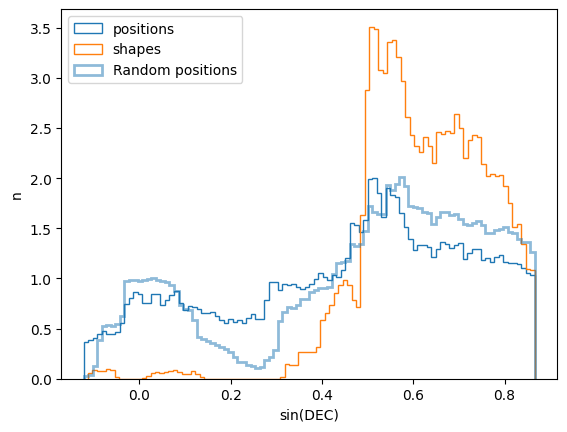

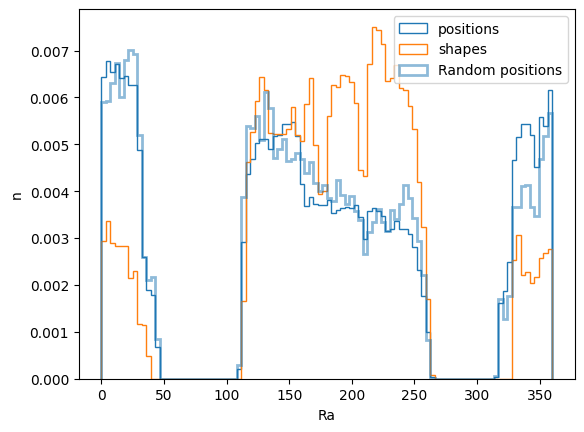

In [54]:
plt.figure()
plt.hist( galaxies['Z'] ,100,histtype='step',density=True,label='positions')
plt.hist( randoms['Z'] ,100,histtype='step',density=True,label='eboss randoms')
plt.hist( shape_position_catalogue['redshift'],100,histtype='step',density=True,label='shapes')
# plt.hist(random_positions[redshift],100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
# plt.hist(random_shapes[redshift],100,histtype='step',density=True,label='Random shapes',lw=2,alpha=0.5,color='C1')
plt.xlabel(redshift)
plt.ylabel('n')
plt.legend()


plt.figure()
plt.hist(np.sin(np.deg2rad(galaxies['DEC'])),100,histtype='step',density=True,label='positions')
plt.hist(np.sin(np.deg2rad(shape_position_catalogue['Dec'])),100,histtype='step',density=True,label='shapes')
plt.hist(np.sin(np.deg2rad(randoms[dec])),100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
plt.xlabel('sin('+dec+')')
plt.ylabel('n')
plt.legend()

plt.figure()
plt.hist(galaxies['RA'],100,histtype='step',density=True,label='positions')
plt.hist(shape_position_catalogue['RA'],100,histtype='step',density=True,label='shapes')
plt.hist(randoms['RA'],100,histtype='step',density=True,label='Random positions',lw=2,alpha=0.5,color='C0')
plt.xlabel(ra)
plt.ylabel('n')
plt.legend()

In [55]:
chi_shapes = cosmo.comoving_distance( shape_position_catalogue[redshift] ).value
chi_positions = cosmo.comoving_distance( galaxy_sample['Z'] ).value

/softs/intelpython/intelpython3-2025.0.0_71/lib/python3.12/site-packages/astropy/cosmology/flrw/lambdacdm.py:397: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1.0 / 6, 1.0 / 2, 7.0 / 6, -(x**3))


In [56]:
import pandas as pd

In [61]:
galaxies.columns

ColDefs(
    name = 'RUN'; format = 'I'; null = 16959
    name = 'CAMCOL'; format = 'I'; null = 16959
    name = 'FIELD'; format = 'I'; null = 16959
    name = 'ID'; format = 'I'; null = 16959
    name = 'RERUN'; format = '12A'
    name = 'FIBER2MAG'; format = '5E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'PSFFLUX'; format = '5E'
    name = 'PSFFLUX_IVAR'; format = '5E'
    name = 'EXTINCTION'; format = '5E'
    name = 'FIBER2FLUX'; format = '5E'
    name = 'FIBER2FLUX_IVAR'; format = '5E'
    name = 'MODELFLUX'; format = '5E'
    name = 'MODELFLUX_IVAR'; format = '5E'
    name = 'MODELMAG'; format = '5E'
    name = 'W1_MAG'; format = 'E'
    name = 'W1_MAG_ERR'; format = 'E'
    name = 'W1_NANOMAGGIES'; format = 'E'
    name = 'W1_NANOMAGGIES_IVAR'; format = 'E'
    name = 'W2_NANOMAGGIES'; format = 'E'
    name = 'W2_NANOMAGGIES_IVAR'; format = 'E'
    name = 'OBJID_TARGETING'; format = 'K'; null = 999999
    name = 'CHUNK'; format = 'J'; null = 999999


In [65]:
# Extract only 1D columns from the galaxy sample
columns_to_use = ['RA', 'DEC', 'Z',  'WEIGHT_CP']
positions = pd.DataFrame({col: galaxies[col] for col in columns_to_use})

In [66]:
# Create the DataFrame
shapes = pd.DataFrame.from_records( shape_position_catalogue )

In [67]:
random_positions = pd.DataFrame.from_records( randoms )

In [68]:
positions.shape, shapes.shape, random_positions.shape

((311848, 4), (124450, 8), (8914172, 8))

In [69]:
positions[redshift] = positions['Z']
positions['w'] = np.ones( len( positions ))
shapes['w'] = shapes['w_iv']
shapes['DEC'] = shapes['Dec']
random_positions[redshift] = random_positions['Z']


In [70]:
random_positions = random_positions.iloc[::5].copy()

In [71]:
len( eboss_randoms ) / len( random_positions )

3.0629413265950016

In [73]:
d = 'd'

positions.loc[:,d] = cosmo.comoving_distance(positions[redshift]).value
shapes.loc[:,d]    = cosmo.comoving_distance(shapes[redshift]).value

random_positions[d] = cosmo.comoving_distance(random_positions[redshift]).value

/softs/intelpython/intelpython3-2025.0.0_71/lib/python3.12/site-packages/astropy/cosmology/flrw/lambdacdm.py:397: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(x) * hyp2f1(1.0 / 6, 1.0 / 2, 7.0 / 6, -(x**3))


In [82]:
np.min( positions['d'])

-21.437811213678128

In [76]:
positions['x'] = positions[d]*np.cos(np.deg2rad(positions['DEC']))*np.cos(np.deg2rad(positions['RA']))
positions['y'] = positions[d]*np.cos(np.deg2rad(positions['DEC']))*np.sin(np.deg2rad(positions['RA']))
positions['z'] = positions[d]*np.sin(np.deg2rad(positions['DEC']))

shapes['x'] = shapes[d]*np.cos(np.deg2rad(shapes['DEC']))*np.cos(np.deg2rad(shapes['RA']))
shapes['y'] = shapes[d]*np.cos(np.deg2rad(shapes['DEC']))*np.sin(np.deg2rad(shapes['RA']))
shapes['z'] = shapes[d]*np.sin(np.deg2rad(shapes['DEC']))

In [77]:
shapes['e1'].values

array([ 0.29325408,  0.18666531, -0.10850574, ..., -0.21012516,
       -0.24436595, -0.17914414], dtype='>f4')

In [78]:
num_nans = shapes['e1'].isna().sum()
print(f"Number of NaNs: {num_nans}")


Number of NaNs: 0


In [79]:
num_nans = shapes['e2'].isna().sum()
print(f"Number of NaNs: {num_nans}")

Number of NaNs: 0


In [80]:
num_nans = shapes['w'].isna().sum()
print(f"Number of NaNs: {num_nans}")

Number of NaNs: 0


In [81]:
position_catalogue = treecorr.Catalog( x=positions['x'], 
                                       y=positions['y'], 
                                       z=positions['z'],
                                       w=positions['w'])
shape_catalogue = treecorr.Catalog( x=shapes['x'], 
                                    y=shapes['y'], 
                                    z=shapes['z'], 
                                    g1 = shapes['e1'],
                                    g2 = shapes['e2'], 
                                    w=shapes['w'])


In [84]:
random_positions['x'] = random_positions[d]*np.cos(np.deg2rad(random_positions['DEC']))*np.cos(np.deg2rad(random_positions['RA']))
random_positions['y'] = random_positions[d]*np.cos(np.deg2rad(random_positions['DEC']))*np.sin(np.deg2rad(random_positions['RA']))
random_positions['z'] = random_positions[d]*np.sin(np.deg2rad(random_positions['DEC']))

In [85]:
random_position_catalogue = treecorr.Catalog( x=random_positions['x'], 
                                              y=random_positions['y'], 
                                              z=random_positions['z'])

In [86]:
# Function to process a single rpar bin
def process_rpar_bin(min_rpar, max_rpar , min_sep, max_sep, nbins ):
    print('Running between rpar =', min_rpar, 'and rpar =', max_rpar)

    # Create the NNCorrelation objects
    nn = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear') 
    rr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear') 
    dr = treecorr.NNCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear')

    # Process the position and random catalogues
    nn.process(position_catalogue, position_catalogue, metric='Rperp')
    rr.process(random_position_catalogue, random_position_catalogue, metric='Rperp')
    dr.process(position_catalogue, random_position_catalogue, metric='Rperp')

    # Calculate the Landy-Szalay estimator
    xi, varxi = nn.calculateXi(rr=rr, dr=dr)
    r = np.exp(nn.meanlogr)
    sig = np.sqrt(varxi)

    return xi, r

In [109]:
# Define the range and number of bins for rpar
#rpar_bins = np.linspace(-150, 150, 51)  
rpar_bins = np.linspace(-150, 150, 5)  

# Define the parameters for the correlation function
min_sep = 0  # Minimum separation in Mpc
max_sep = 150  # Maximum separation in Mpc
nbins = 25     # Number of bins
bin_slop = 0.5 # Bin slop

In [110]:
# Initialize lists to store results
xi_results = []
r_results = []

# Iterate over rpar bins
for i in range(len(rpar_bins) - 1):

    min_rpar = rpar_bins[i]
    max_rpar = rpar_bins[i + 1]

    xi , r = process_rpar_bin( min_rpar, max_rpar , min_sep , max_sep , nbins )

    # Store the results
    xi_results.append(xi)
    r_results.append(r)

Running between rpar = -150.0 and rpar = -75.0
Running between rpar = -75.0 and rpar = 0.0
Running between rpar = 0.0 and rpar = 75.0
Running between rpar = 75.0 and rpar = 150.0


In [111]:
xi_results = np.array(xi_results)

In [112]:
xi_results.shape

(4, 25)

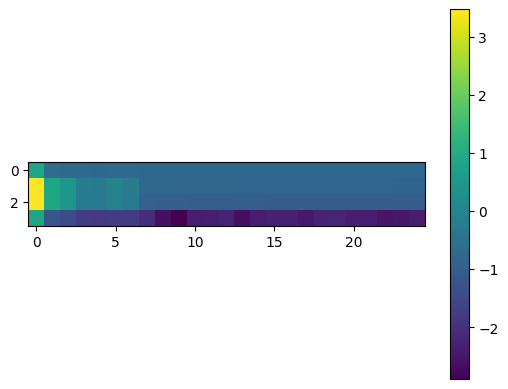

In [113]:
plt.imshow( np.log10( xi_results ) )
plt.colorbar()

In [114]:
r.shape

(25,)

In [115]:
# Assuming r_perp_bins and r_par_bins are defined
r_perp_cents = r
r_par_cents = ( rpar_bins[1:] + rpar_bins[:-1] )/2.

# Flatten the xi_results and r_results arrays
xi_flat = np.array(xi_results).flatten()
r_perp_flat = np.array([r_perp_cents] * len(r_par_cents)).flatten()
r_par_flat = np.array([[r_par] * len(r_perp_cents) for r_par in r_par_cents]).flatten()



In [116]:
r_par_flat.shape, r_perp_flat.shape, xi_flat.shape

((100,), (100,), (100,))

In [117]:
# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

In [118]:
np.min( s ) , np.max( s )

(37.503889035018396, 185.11322942590462)

In [119]:
# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

# Define bins for s
s_bins = np.linspace( 50 , 250 , 40)

# Initialize arrays to store the results
xi_s = np.zeros(len(s_bins) - 1)
var_xi_s = np.zeros(len(s_bins) - 1)
counts = np.zeros(len(s_bins) - 1)

# Bin the results by s and calculate the radial averages and variances
for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
    if np.any(mask):  # Check if there are any elements in the mask
        xi_s[i] = np.mean(xi_flat[mask])
        var_xi_s[i] = np.var(xi_flat[mask])
        counts[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_s[counts == 0] = np.nan
var_xi_s[counts == 0] = np.nan

In [120]:
s_cents = ( s_bins[1:] + s_bins[:-1] )/2.

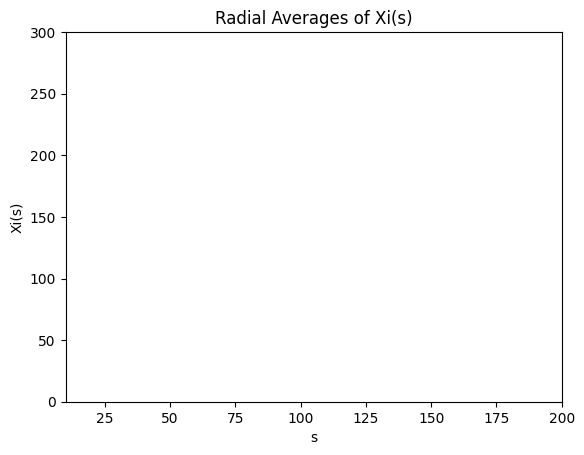

In [121]:
plt.errorbar( s_cents , xi_s * s_cents**2, fmt='o' , yerr = var_xi_s**0.5  * s_cents**2 / counts**0.5 )
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
plt.xlim( 10 , 200 )
plt.ylim( -0.01 , 0.03 * 100**2 )
plt.show()

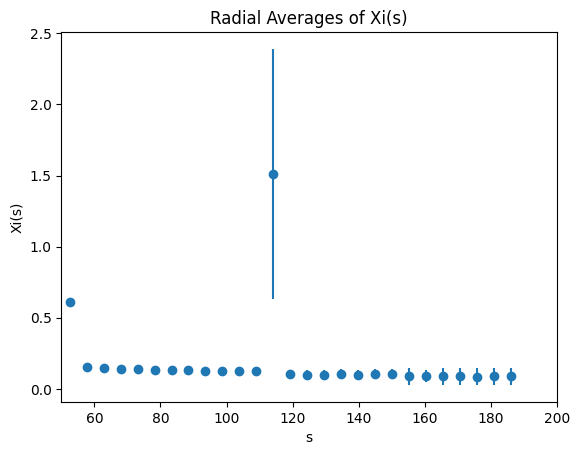

In [122]:
plt.errorbar( s_cents , xi_s , fmt='o' , yerr = var_xi_s**0.5 / counts**0.5 )
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
plt.xlim( 50 , 200 )
#plt.ylim( -0.01 , 0.03  )
plt.show()

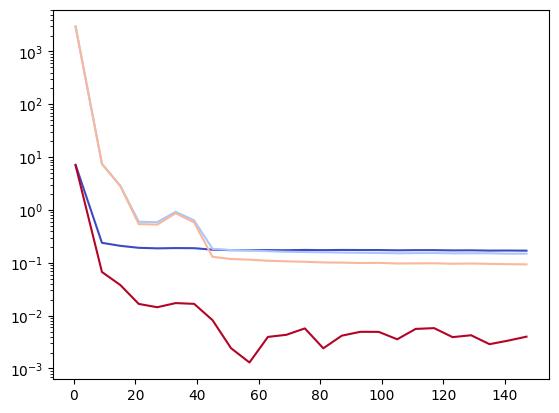

In [123]:
colors = plt.cm.coolwarm(np.linspace(0, 1, len(xi_results)))

for xi, color in zip(xi_results, colors):
    plt.plot(r, xi, color=color)
    plt.yscale('log')

plt.show()

In [50]:
# Shear stuff
# Function to process a single rpar bin
def process_ng_rpar_bin(min_rpar, max_rpar , min_sep = min_sep, max_sep = max_sep, nbins = nbins):
    print('Running between rpar =', min_rpar, 'and rpar =', max_rpar)

    # Create the NNCorrelation objects
    ng = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear') 
    rg = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar, bin_type='Linear') 

    # Process the position and random catalogues
    ng.process(position_catalogue, shape_catalogue, metric='Rperp')
    rg.process(random_position_catalogue, shape_catalogue, metric='Rperp')

    # Calculate the Landy-Szalay estimator
    xi_p , xi_x , _ = ng.calculateXi(rg=rg)
    r = np.exp(ng.meanlogr)

    return r , xi_p , xi_x

In [114]:
# Define the range and number of bins for rpar
rpar_bins = np.linspace(-150, 150, 51)  

# Define the parameters for the correlation function
min_sep = 0  # Minimum separation in Mpc
max_sep = 150  # Maximum separation in Mpc
nbins = 25     # Number of bins
bin_slop = 0.1 # Bin slop

In [115]:
# Initialize lists to store results
xi_gn_p_results = []
xi_gn_x_results = []
r_results = []

# Iterate over rpar bins
for i in range(len(rpar_bins) - 1):

    min_rpar = rpar_bins[i]
    max_rpar = rpar_bins[i + 1]

    r , xi_p , xi_x = process_ng_rpar_bin( min_rpar, max_rpar , min_sep , max_sep , nbins )

    # Store the results
    xi_gn_p_results.append( xi_p )
    xi_gn_x_results.append( xi_x )
    r_results.append(r)

Running between rpar = -150.0 and rpar = -144.0
Running between rpar = -144.0 and rpar = -138.0
Running between rpar = -138.0 and rpar = -132.0
Running between rpar = -132.0 and rpar = -126.0
Running between rpar = -126.0 and rpar = -120.0
Running between rpar = -120.0 and rpar = -114.0
Running between rpar = -114.0 and rpar = -108.0
Running between rpar = -108.0 and rpar = -102.0
Running between rpar = -102.0 and rpar = -96.0
Running between rpar = -96.0 and rpar = -90.0
Running between rpar = -90.0 and rpar = -84.0
Running between rpar = -84.0 and rpar = -78.0
Running between rpar = -78.0 and rpar = -72.0
Running between rpar = -72.0 and rpar = -66.0
Running between rpar = -66.0 and rpar = -60.0
Running between rpar = -60.0 and rpar = -54.0
Running between rpar = -54.0 and rpar = -48.0
Running between rpar = -48.0 and rpar = -42.0
Running between rpar = -42.0 and rpar = -36.0
Running between rpar = -36.0 and rpar = -30.0
Running between rpar = -30.0 and rpar = -24.0
Running between r

In [116]:
xi_gn_p_results = np.array(xi_gn_p_results)
xi_gn_x_results = np.array(xi_gn_x_results)

/softs/intelpython/intelpython3-2025.0.0_71/lib/python3.12/site-packages/matplotlib/colors.py:749: RuntimeWarning: invalid value encountered in less
  mask_under = xa < 0
/softs/intelpython/intelpython3-2025.0.0_71/lib/python3.12/site-packages/matplotlib/colors.py:750: RuntimeWarning: invalid value encountered in greater_equal
  mask_over = xa >= self.N


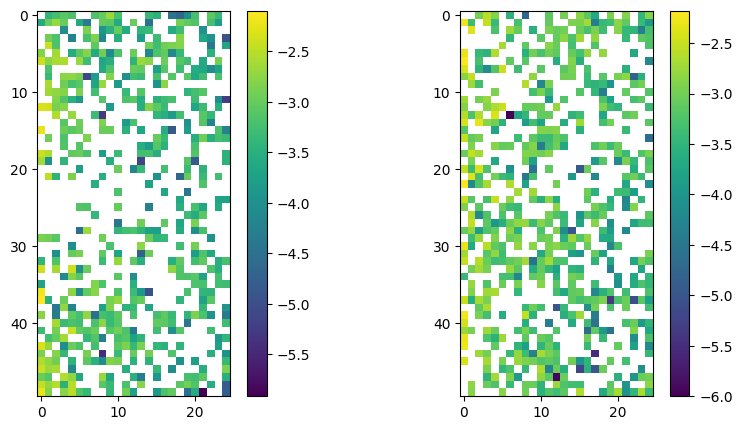

In [117]:
plt.figure( figsize = ( 10 , 5 ))
plt.subplot(121)
plt.imshow( np.log10( xi_gn_p_results ) )
plt.colorbar()

plt.subplot(122)
plt.imshow( np.log10( xi_gn_x_results ) )
plt.colorbar()

In [118]:
# Assuming r_perp_bins and r_par_bins are defined
r_perp_cents = r
r_par_cents = ( rpar_bins[1:] + rpar_bins[:-1] )/2.

# Flatten the xi_results and r_results arrays
xi_gn_p_flat = np.array(xi_gn_p_results).flatten()
xi_gn_x_flat = np.array(xi_gn_x_results).flatten()
r_perp_flat = np.array([r_perp_cents] * len(r_par_cents)).flatten()
r_par_flat = np.array([[r_par] * len(r_perp_cents) for r_par in r_par_cents]).flatten()

In [175]:
# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

# Define bins for s
s_bins = np.linspace( 50 , 250 , 40)
s_cents = ( s_bins[1:] + s_bins[:-1] )/2.

# Initialize arrays to store the results
xi_p_s = np.zeros(len(s_bins) - 1)
var_xi_p_s = np.zeros(len(s_bins) - 1)
counts_p = np.zeros(len(s_bins) - 1)

xi_x_s = np.zeros(len(s_bins) - 1)
var_xi_x_s = np.zeros(len(s_bins) - 1)
counts_x = np.zeros(len(s_bins) - 1)

# Bin the results by s and calculate the radial averages and variances
for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
    if np.any(mask):  # Check if there are any elements in the mask
        xi_p_s[i] = np.mean(xi_gn_p_flat[mask])
        var_xi_p_s[i] = np.var(xi_gn_p_flat[mask])
        counts_p[i] = np.sum(mask)

        xi_x_s[i] = np.mean(xi_gn_x_flat[mask])
        var_xi_x_s[i] = np.var(xi_gn_x_flat[mask])
        counts_x[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_p_s[counts_p == 0] = np.nan
var_xi_p_s[counts_p == 0] = np.nan

xi_x_s[counts_x == 0] = np.nan
var_xi_x_s[counts_x == 0] = np.nan

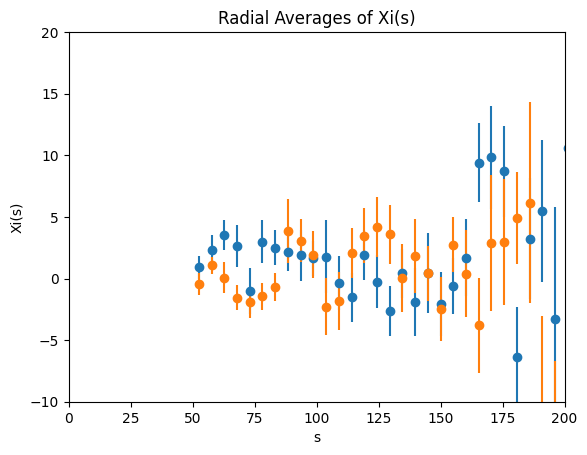

In [176]:
plt.errorbar( s_cents , -xi_p_s * s_cents**2, fmt='o' , yerr = var_xi_p_s**0.5  * s_cents**2 / counts_x**0.5 )
plt.errorbar( s_cents , -xi_x_s * s_cents**2, fmt='o' , yerr = var_xi_x_s**0.5  * s_cents**2 / counts_p**0.5 )
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
plt.xlim( 0 , 200 )
plt.ylim( -10 , 20 )
#plt.ylim( -0.01 , 0.03 * 100**2 )
plt.show()

In [1]:
plt.errorbar( s_cents , -xi_p_s, fmt='o' , yerr = var_xi_p_s**0.5 / counts_x**0.5 )
plt.errorbar( s_cents , xi_s , fmt='o' , yerr = var_xi_s**0.5 / counts**0.5 )

#plt.errorbar( s_cents , -xi_x_s, fmt='o' , yerr = var_xi_x_s**0.5 / counts_p**0.5 )
plt.plot( s_cents , np.zeros( s_cents.shape ) , 'k--')
plt.xlabel('s')
plt.ylabel('Xi(s)')
plt.title('Radial Averages of Xi(s)')
plt.xlim( 50 , 200 )
plt.ylim( -0.001 , 0.001 ) 
#plt.yscale('log')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Create the NNCorrelation objects
ng = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar) 
rg = treecorr.NGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, min_rpar=min_rpar, max_rpar=max_rpar) 

In [ ]:
# Process the position and random catalogues
ng.process( position_catalogue , shape_catalogue , metric ='Rperp' )
rg.process( random_position_catalogue , shape_catalogue, metric ='Rperp' )

In [ ]:
xi_p = ng.raw_xi
xim_p = ng.xi_im 

<>:8: SyntaxWarning: invalid escape sequence '\X'
<>:8: SyntaxWarning: invalid escape sequence '\X'
/tmp/ipykernel_122941/3597713004.py:8: SyntaxWarning: invalid escape sequence '\X'
  plt.title('Landy-Szalay Correlation Function $\Xi(s)$')


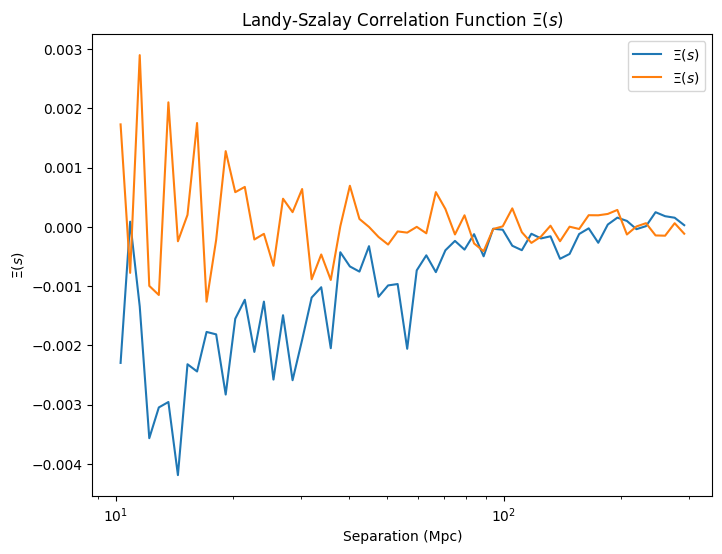

In [ ]:
# Plot the correlation function
plt.figure(figsize=(8, 6))
plt.plot(r, xi_p, label=r'$\Xi(s)$')
plt.plot(r, xim_p, label=r'$\Xi(s)$')
plt.xscale('log')
plt.xlabel('Separation (Mpc)')
plt.ylabel(r'$\Xi(s)$')
plt.title('Landy-Szalay Correlation Function $\Xi(s)$')
plt.legend()
plt.show()

In [38]:
from ia_corr import compute_2p_corr

In [41]:
# parameters related with bins
nbins = 10 # number of radial bins
rmin = 0.1 # minimum value for rp (r in case of the quadrupole)
rmax = 200. # maximum value for rp (r in case of the quadrupole)
pi_max = 15. # maximum value along l.o.s. (Pi) 
npi = 5 # number of bins in Pi
mubins = 10 # number of bins in mu
grid_resolution = 10 # Controls the resolution of the r,mu grid to compute the quadrupole, 
#you can lower this value for a faster computation but it's going to compute wgp2 only at larger radius

# Related to JK patches
NPatches = 15 #int(nbins**(3./2.))
print('Number of patches',NPatches)
# Other configuration parameters
ncores = 30 # Number of cores to run in parallel
slop = 0.1 # Resolution for treecorr
box = False # Indicates if the data corresponds to a box, otherwise it will assume a lightcone
exact_position = False # Indicates if the coordinates are exactly provided (e.g. simulated data 
# without any error added in the position). Otherwise it will assume that the positions are not
# exact and will use ra, dec to match the catalogues. If this parameter is set as True, it
# will neglect box and it will set it as False
sky_threshold = 1.0 # Threshold for matching the catalogues in arcsecond, used if exact_position
#is set to True.
grid_resolution = 10 # Resolution of the grid used to compute the quadrupole, a lower number will
#speed up the computation but reaches to larger radial distances.

Number of patches 15


In [42]:
col_names = ['RA','DEC','d','e1','e2', 'w']

config = {'col_names': col_names,
          'nbins': nbins,
          'rmin': rmin,
          'rmax': rmax,
          'pi_max': pi_max,
          'npi': npi,
          'grid_resolution': grid_resolution,
          'mubins': mubins,
          'NPatches': NPatches,
          'ncores': ncores,
          'slop': slop,
          'box': box,
          'exact_position': exact_position,
          'sky_threshold': sky_threshold,
          'grid_resolution': grid_resolution
         }

In [43]:
corr = compute_2p_corr(positions,shapes,random_positions,random_shapes,config)


{'col_names': ['RA', 'DEC', 'd', 'e1', 'e2', 'w'], 'nbins': 10, 'rmin': 0.1, 'rmax': 200.0, 'pi_max': 15.0, 'npi': 5, 'grid_resolution': 10, 'mubins': 10, 'NPatches': 15, 'ncores': 30, 'slop': 0.1, 'box': False, 'exact_position': False, 'sky_threshold': 1.0}


In [44]:
corr.compute_wgg()

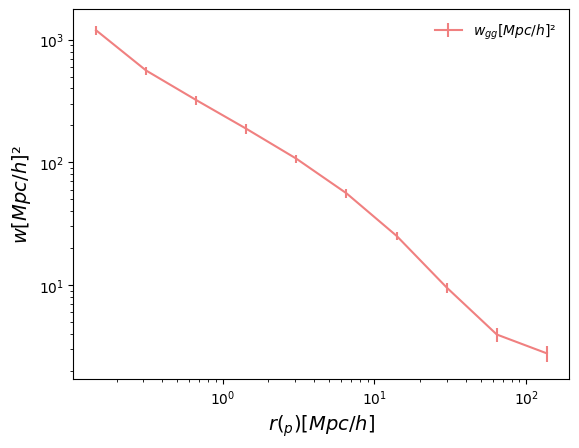

In [45]:
plt.errorbar(corr.wgg.rp,corr.wgg.xip,yerr=corr.wgg.std_from_cov,label=r'$w_{gg}[Mpc/h]²$',c='lightcoral')
# plt.errorbar(corr.wgp.rp,corr.wgp.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
# plt.errorbar(corr.wgp2.r,corr.wgp2.xip,yerr=corr.wgp2.std_from_cov,label=r'$w_{g+,2}[Mpc/h]²$',c='brown')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$w[Mpc/h]²$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)

In [46]:
corr.compute_wgp()

The following patch numbers have no objects: {0, 1, 2, 10}
This may be a problem depending on your use case.
The following patch numbers have no objects: {0, 1, 2, 10}
This may be a problem depending on your use case.


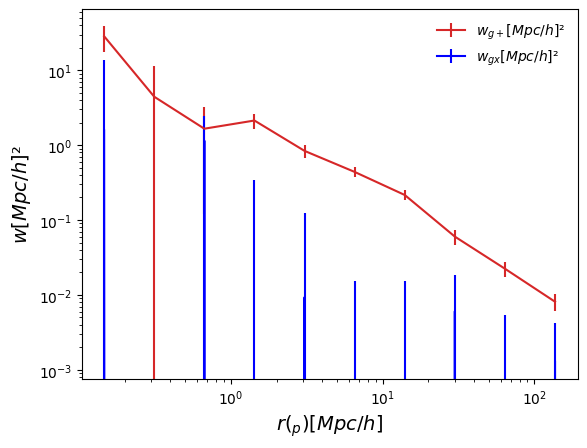

In [49]:
# plt.errorbar(corr.wgg.rp,
#              corr.wgg.xip,yerr=corr.wgg.std_from_cov,label=r'$w_{gg}[Mpc/h]²$',c='lightcoral')
plt.errorbar( corr.wgp.rp,
              -corr.wgp.xip,
              yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
plt.errorbar( corr.wgp.rp,
              corr.wgx.xip,
              yerr=corr.wgx.std_from_cov,label=r'$w_{gx}[Mpc/h]²$',c='b')
# plt.errorbar(corr.wgp.rp,-corr.wgp.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
# plt.errorbar(corr.wgp2.r,corr.wgp2.xip,yerr=corr.wgp2.std_from_cov,label=r'$w_{g+,2}[Mpc/h]²$',c='brown')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$w[Mpc/h]²$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)

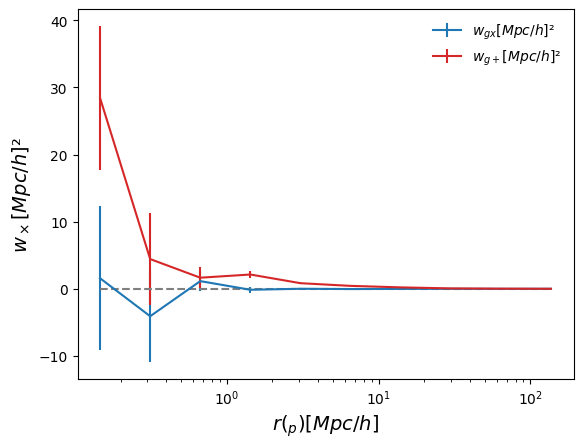

In [51]:
plt.errorbar(corr.wgp.rp,corr.wgx.xip,yerr=corr.wgp.std_from_cov,label=r'$w_{gx}[Mpc/h]²$',c='C0')
plt.errorbar( corr.wgp.rp,
              -corr.wgp.xip,
              yerr=corr.wgp.std_from_cov,label=r'$w_{g+}[Mpc/h]²$',c='C3')
plt.plot(corr.wgp.rp,corr.wgp.rp*0.,'C7--')
plt.xscale('log')
plt.ylabel(r'$w_\times[Mpc/h]²$',fontsize=14)
plt.xlabel(r'$r(_p) [Mpc/h]$',fontsize=14)
plt.legend(frameon=False)

In [ ]:
# Prepare the data for TreeCorr
# shape_catalogue = treecorr.Catalog( ra=matched_shape_ra, 
#                                     dec=matched_shape_dec,
#                                     g1=matched_shape_e1, 
#                                     g2=matched_shape_e2 , 
#                                     w = matched_shape_w , 
#                                     r = r_shapes ,
#                                     ra_units='deg', dec_units='deg')


# position_catalogue = treecorr.Catalog( ra = galaxy_sample['RA'],
#                                        dec = galaxy_sample['DEC'] , 
#                                        r = r_positions , 
#                                        w = galaxy_sample['WEIGHT_ALL_NOFKP'] , 
#                                        ra_units='deg', 
#                                        dec_units='deg' )

shape_catalogue = treecorr.Catalog( ra=matched_shape_ra, 
                                    dec=matched_shape_dec,
                                    g1=matched_shape_e1, 
                                    g2=matched_shape_e2 , 
                                    w = matched_shape_w , 
                                    #r = r_shapes ,
                                    ra_units='deg', dec_units='deg')


position_catalogue = treecorr.Catalog( ra = galaxy_sample['RA'],
                                       dec = galaxy_sample['DEC'] , 
                                       #r = r_positions , 
                                       w = galaxy_sample['WEIGHT_ALL_NOFKP'] , 
                                       ra_units='deg', 
                                       dec_units='deg' )

In [ ]:
max_rpar = 20

In [ ]:
#gg = treecorr.GGCorrelation( nbins=20, min_sep=0.1, max_sep=100, max_rpar=max_rpar)
gg = treecorr.GGCorrelation( nbins=20, min_sep=0.1, max_sep=100,sep_units='arcmin' )

gg.process( shape_catalogue )

xip = gg.xip  # The xi_plus correlation function
xim = gg.xim  # The xi_minus correlation function

In [ ]:
galaxy_redshift_cut = ( galaxy_sample['Z'] > 0.6 )  &  ( galaxy_sample['Z'] < 0.65 )
shape_redshift_cut = ( matched_galaxy_redshift > 0.6 )  &  ( matched_galaxy_redshift < 0.65 )

In [ ]:
len( matched_shape_ra[shape_redshift_cut] ), len( galaxy_sample['RA'][galaxy_redshift_cut] )

In [ ]:
shape_catalogue = treecorr.Catalog( ra=matched_shape_ra[shape_redshift_cut], 
                                    dec=matched_shape_dec[shape_redshift_cut],
                                    g1=matched_shape_e1[shape_redshift_cut], 
                                    g2=matched_shape_e2[shape_redshift_cut] , 
                                    w = matched_shape_w[shape_redshift_cut] , 
                                    #r = r_shapes ,
                                    ra_units='deg', dec_units='deg')


position_catalogue = treecorr.Catalog( ra = galaxy_sample['RA'][galaxy_redshift_cut],
                                       dec = galaxy_sample['DEC'][galaxy_redshift_cut] , 
                                       #r = r_positions , 
                                       w = galaxy_sample['WEIGHT_ALL_NOFKP'][galaxy_redshift_cut] , 
                                       ra_units='deg', 
                                       dec_units='deg' )

In [ ]:
nn = treecorr.NNCorrelation( min_sep=.1, max_sep=60., bin_size=0.1, sep_units='degrees'  )

nn.process( position_catalogue , position_catalogue )
print(nn.__dict__.keys())

In [ ]:
rand = treecorr.Catalog(ra=random_positions[ra], dec=random_positions[dec], ra_units='degrees', dec_units='degrees')
rr = treecorr.NNCorrelation( min_sep=.1, max_sep=60., bin_size=0.1, sep_units='degrees')
rr.process(rand)


In [ ]:
dr = treecorr.NNCorrelation( min_sep=.1, max_sep=60., bin_size=0.1, sep_units='degrees' )
dr.process( position_catalogue , rand)

In [ ]:


xi, varxi = nn.calculateXi(rr=rr, dr=dr)
sig = np.sqrt(varxi)

In [ ]:

r = np.exp(nn.meanlogr)
sig = np.sqrt(varxi)

plt.plot(r, xi, color='blue')
plt.plot(r, -xi, color='blue', ls=':')
plt.errorbar(r[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=0.1, ls='')
plt.errorbar(r[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
leg = plt.errorbar(-r, xi, yerr=sig, color='blue')

plt.xscale('log')
plt.yscale('log', nonpositive='clip')
plt.xlabel(r'$\theta$ (degrees)')

plt.legend([leg], [r'$w(\theta)$'], loc='lower left')
# plt.xlim([0.01,10])
plt.show()



In [ ]:
ng = treecorr.NGCorrelation( min_sep=.01, max_sep=60., bin_size=0.4, sep_units='degrees' )


ng.process( position_catalogue , shape_catalogue )

ng_xip = ng.xi  # The xi_plus correlation function
ng_xim = ng.xi_im  # The xi_minus correlation function
ngr = np.exp( ng.meanlogr )


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot( ngr , -ng_xip )
plt.plot( ngr ,  ng_xim )
plt.plot( ngr , ng_xip , '--' )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (Mpc/h)')
plt.ylabel('xi_plus')
plt.title('Shear-Shear Correlation Function (xi_plus)')
plt.grid(True)
plt.show()

In [ ]:
data = []
# Define redshift bins
#redshift_bins = [(0.6, 0.65), (0.65, 0.7), (0.7, 0.75), (0.75, 0.8), (0.8, 0.85), (0.9, 0.95), (0.95, 1)]
dz = 0.03
redshift_bins = [(z, z + dz) for z in np.arange(0.6, 1, dz)]

# Loop over redshift bins
for z_min, z_max in redshift_bins:
    galaxy_redshift_cut = (galaxy_sample['Z'] > z_min) & (galaxy_sample['Z'] < z_max)
    shape_redshift_cut = (matched_galaxy_redshift > z_min) & (matched_galaxy_redshift < z_max)

    rgalaxy_redshift_cut = (random_positions[redshift] > z_min) & ( random_positions[redshift]  < z_max)
    rshape_redshift_cut = (random_shapes[redshift] > z_min) & ( random_shapes[redshift]  < z_max)

    shape_catalogue = treecorr.Catalog(
        ra=matched_shape_ra[shape_redshift_cut],
        dec=matched_shape_dec[shape_redshift_cut],
        g1=matched_shape_e1[shape_redshift_cut],
        g2=matched_shape_e2[shape_redshift_cut],
        w=matched_shape_w[shape_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    position_catalogue = treecorr.Catalog(
        ra=galaxy_sample['RA'][galaxy_redshift_cut],
        dec=galaxy_sample['DEC'][galaxy_redshift_cut],
        w=galaxy_sample['WEIGHT_ALL_NOFKP'][galaxy_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    random_position_catalogue = treecorr.Catalog(
        ra=random_positions[ra][rgalaxy_redshift_cut],
        dec=random_positions[dec][rgalaxy_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    random_shape_catalogue = treecorr.Catalog(
        ra=random_shapes[ra][rshape_redshift_cut],
        dec=random_shapes[dec][rshape_redshift_cut],
        ra_units='deg',
        dec_units='deg'
    )

    ng = treecorr.NGCorrelation(min_sep=.01, max_sep=600., bin_size=0.35, sep_units='degrees')
    rg = treecorr.NGCorrelation(min_sep=.01, max_sep=600., bin_size=0.35, sep_units='degrees')
    #rr = treecorr.NNCorrelation(min_sep=.001, max_sep=600., bin_size=0.15, sep_units='degrees')

    ng.process(position_catalogue, shape_catalogue)
    rg.process(random_position_catalogue, shape_catalogue)
    #rr.process(random_position_catalogue, random_shape_catalogue)

    ng_xip =  ng.xi - rg.xi
    ng_xim = ng.xi_im - rg.xi_im  # The xi_minus correlation function
    varxi = ng.varxi  # The variance of the correlation function
    ngr = np.exp(ng.meanlogr)

    print( len( ngr ), len( ng_xip ), len( ng_xim ), len( varxi ) )

    data.append( [ngr, ng_xip, ng_xim, varxi] )

In [ ]:
len( data )

In [ ]:
data = np.array( data )

In [ ]:
data[:, 3][ data[:, 3] == 0] = 1e-10

In [ ]:
# Calculate the weighted mean
weighted_mean = np.average(data[:, 1], axis=0, weights=1/data[:, 3])
weighted_mean_im = np.average(data[:, 2], axis=0, weights=1/data[:, 3])

# Calculate the weighted variance
weighted_variance = np.average(data[:, 3], axis=0, weights=1/data[:, 3])

# Calculate the weighted standard deviation (error)
weighted_err = (weighted_variance)**0.5

# Plot the results
plt.figure(figsize=(8, 6))
plt.errorbar(ngr, -weighted_mean, yerr=weighted_err, fmt='--')
plt.errorbar(ngr, -weighted_mean_im, yerr=weighted_err, fmt='--')
#plt.errorbar(ngr, weighted_mean, yerr=weighted_err, fmt='--')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Separation (degrees)')
plt.ylabel('xi_plus')
plt.title('Weighted Mean and Error of xi_plus')
plt.grid(True)
plt.show()